# **Importing all required modules**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from skimage.transform import resize
%matplotlib inline
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from IPython.display import display
from PIL import Image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import os
from os import listdir
from os.path import isfile, join

# **Visualizing Images**

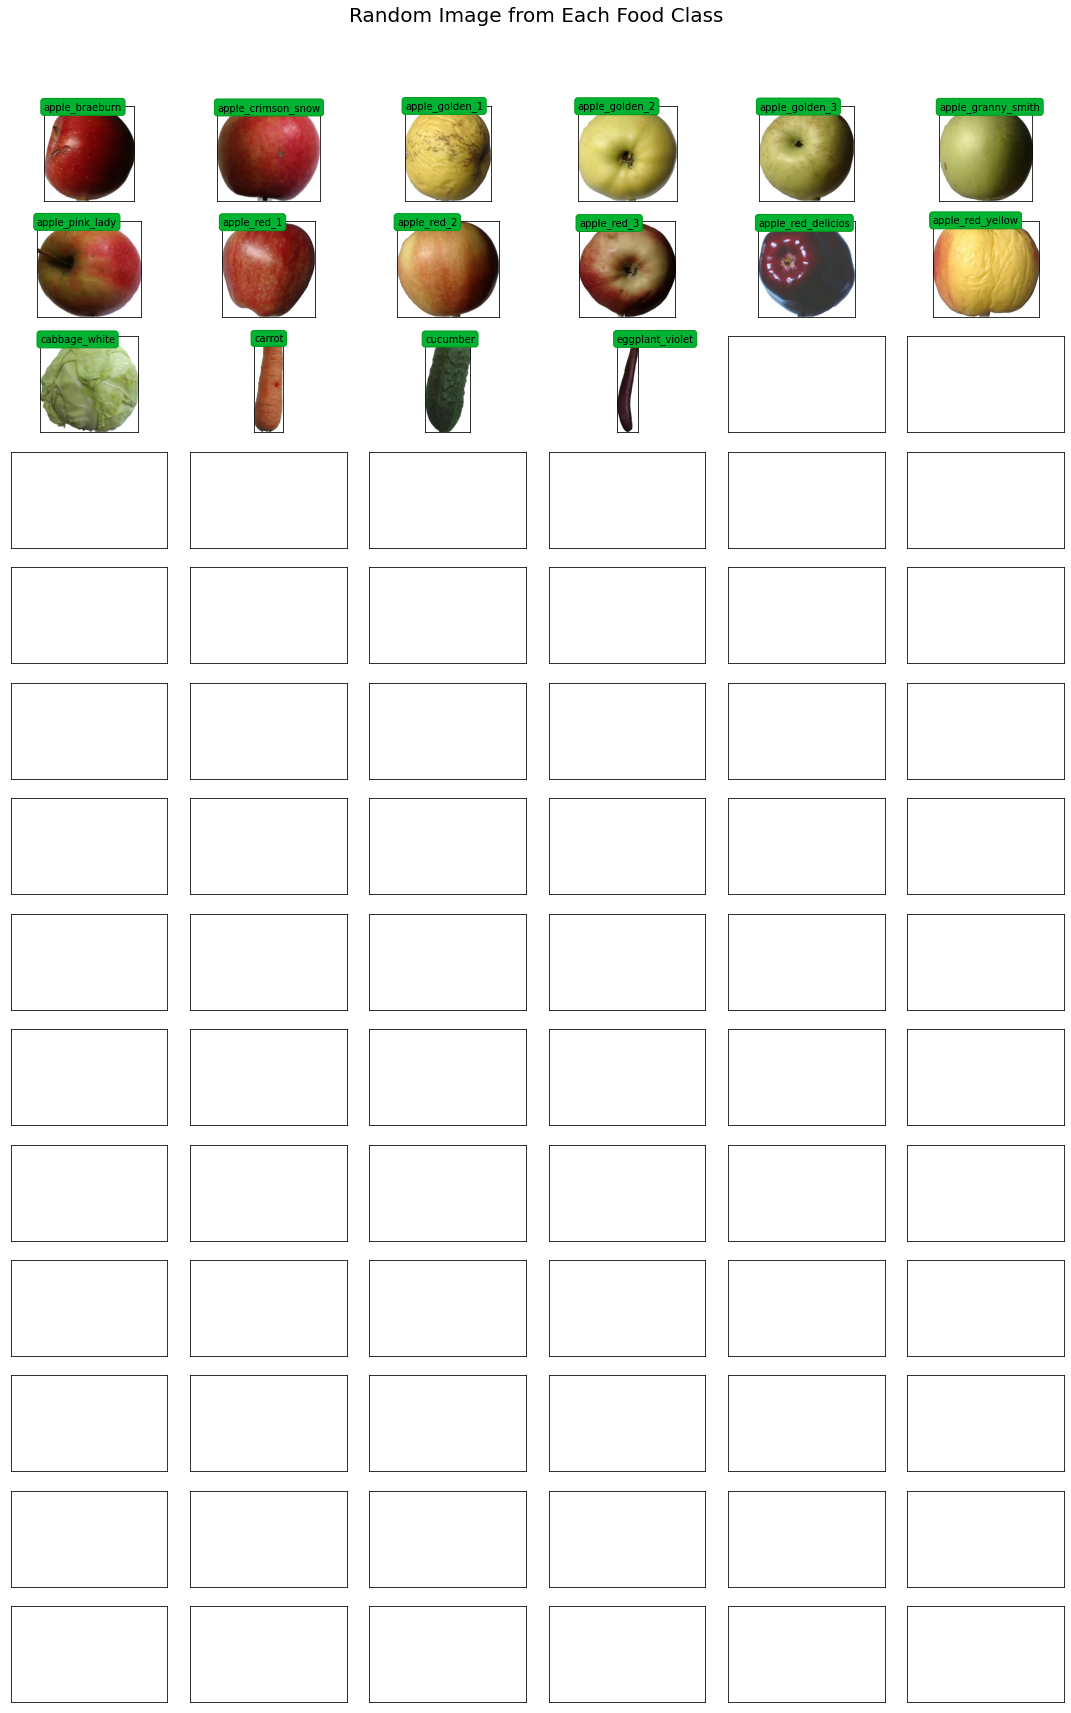

In [2]:
root_dir = '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training'
rows = 14
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# **Loading the data**

In [3]:
# define function to load train and test datasets
def load_dataset(path):
    data = load_files(path)
    fruit_files = np.array(data['filenames'])
    fruit_targets = np_utils.to_categorical(np.array(data['target']))
    return fruit_files, fruit_targets

# load train and test datasets
train_files, train_targets = load_dataset('../input/fruits/fruits-360-original-size/fruits-360-original-size/Training')
test_files, test_targets = load_dataset('../input/fruits/fruits-360-original-size/fruits-360-original-size/Test')

# load list of fruits names
fruit_names = [item[75:] for item in sorted(glob("../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/*"))]

# print statistics about the dataset
print('There are %d total fruit categories.' % len(fruit_names))
print('There are %s total fruit images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training fruit images.' % len(train_files))
print('There are %d test fruit images.'% len(test_files))
print(train_files[:5])

There are 16 total fruit categories.
There are 6272 total fruit images.

There are 4183 training fruit images.
There are 2089 test fruit images.
['../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r_38.jpg'
 '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/apple_braeburn/226.jpg'
 '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/apple_pink_lady/r_144.jpg'
 '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/apple_crimson_snow/r_214.jpg'
 '../input/fruits/fruits-360-original-size/fruits-360-original-size/Training/apple_crimson_snow/108.jpg']


# **Pre-process the Data**

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [4]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Pre-process the image using path_to_tensor and convert it to 4D tensor and divide it in pixel size of 255.

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2089/2089 [00:09<00:00, 223.18it/s]


**Image represented as histogram**

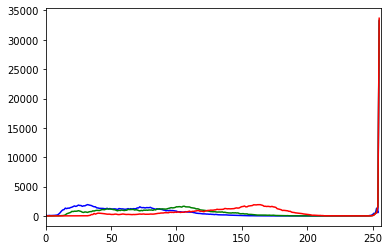

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(train_files[0])
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# **Design the CNN to classify fruits.**

In [7]:
#Defining the architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3

# **Compile the Model**

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# **Train the Model**

In [9]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 25

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='./weights.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_split=0.2,
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/25
168/168 [==============================] - 12s 29ms/step - loss: 1.6250 - accuracy: 0.4978 - val_loss: 0.1680 - val_accuracy: 0.9415

Epoch 00001: val_loss improved from inf to 0.16801, saving model to ./weights.hdf5
Epoch 2/25
168/168 [==============================] - 3s 21ms/step - loss: 0.1621 - accuracy: 0.9457 - val_loss: 0.0251 - val_accuracy: 0.9952

Epoch 00002: val_loss improved from 0.16801 to 0.02510, saving model to ./weights.hdf5
Epoch 3/25
168/168 [==============================] - 4s 21ms/step - loss: 0.0829 - accuracy: 0.9765 - val_loss: 0.5702 - val_accuracy: 0.8339

Epoch 00003: val_loss did not improve from 0.02510
Epoch 4/25
168/168 [==============================] - 4s 23ms/step - loss: 0.0739 - accuracy: 0.9844 - val_loss: 0.0225 - val_accuracy: 0.9976

Epoch 00004: val_loss improved from 0.02510 to 0.02249, saving model to ./weights.hdf5
Epoch 5/25
168/168 [==============================] - 3s 21ms/step - loss: 0.0212 - accuracy: 0.9939 - val_loss: 0.

# **Load the Model with the Best Validation Loss**

In [10]:
model.load_weights('./weights.hdf5')

# **Calculating Accuracy**

In [11]:
# get index of predicted dog breed for each image in test set
fruit_classification = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in train_tensors]

# report test accuracy
train_accuracy = 100*np.sum(np.array(fruit_classification)==np.argmax(train_targets, axis=1))/len(fruit_classification)
print('Train accuracy: %.4f%%' % train_accuracy)

Train accuracy: 99.9761%


In [12]:
# get index of predicted dog breed for each image in test set
fruit_classification_test = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(fruit_classification_test)==np.argmax(test_targets, axis=1))/len(fruit_classification_test)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.9521%


# **Confusion Matrix**

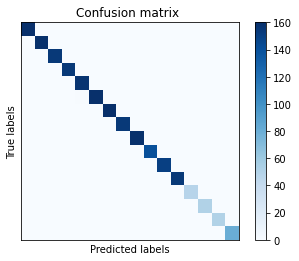

In [13]:
#fruit_classification = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = metrics.confusion_matrix(np.array(fruit_classification_test), np.argmax(test_targets, axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# **Prediction**

In [16]:
def test_model(img_path):
    img=cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    bottleneck=path_to_tensor(img_path)
    predicted_vector=model.predict(bottleneck)
    return fruit_names[np.argmax(predicted_vector)]

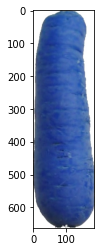

'carrot'

In [19]:
test_model('../input/fruits/fruits-360-original-size/fruits-360-original-size/Test/carrot/103.jpg')